# Coffea package

In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
from hist import Hist
import hist

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights
from coffea.analysis_tools import PackedSelection

plt.style.use(hep.style.CMS)

In [2]:
import yaml
with open("datasets.yaml") as f:
    datasets = yaml.safe_load(f)

# NanoEvents

NanoEvents is a Coffea utility to wrap flat nTuple structures (such as the CMS NanoAOD format) into a single awkward array with appropriate object methods (such as Lorentz vector methods), cross references, and nested objects, all lazily accessed from the source ROOT TTree via uproot. The interpretation of the TTree data is configurable via schema objects, which are community-supplied for various source file types. These schema objects allow a richer interpretation of the file contents than the uproot.lazy methods. Currently available schemas include:

In [3]:
events = NanoEventsFactory.from_root(
    datasets['DYJetsToLL']['files'][0],
    schemaclass=NanoAODSchema.v7,
    metadata={"dataset": "DYJets"},
    entry_stop = 5000
).events()


In [4]:
events

<NanoEventsArray [<event 1:155:385003>, ... ] type='5000 * event'>

In [5]:
events.Jet

<JetArray [[], [Jet, Jet, ... Jet, Jet, Jet, Jet]] type='5000 * var * jet'>

Now the fields of the various object collections are grouped under specific awkward records, such as `Jet`, `Electron` etc

In [6]:
events.fields

['CaloMET',
 'event',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'SoftActivityJetHT',
 'Muon',
 'PuppiMET',
 'Electron',
 'Jet',
 'DeepMETResponseTune',
 'Pileup',
 'SV',
 'L1simulation',
 'LHEWeight',
 'TrigObj',
 'LHEPart',
 'SoftActivityJet',
 'LHE',
 'MET',
 'CorrT1METJet',
 'Photon',
 'genTtbarId',
 'GenJetAK8',
 'boostedTau',
 'run',
 'SoftActivityJetNjets2',
 'LHEScaleWeight',
 'GenIsolatedPhoton',
 'SoftActivityJetNjets10',
 'L1Reco',
 'RawMET',
 'Tau',
 'FatJet',
 'Flag',
 'SoftActivityJetNjets5',
 'GenPart',
 'LowPtElectron',
 'fixedGridRhoFastjetCentralCalo',
 'L1PreFiringWeight',
 'GenMET',
 'GenDressedLepton',
 'btagWeight',
 'GenVisTau',
 'PSWeight',
 'fixedGridRhoFastjetCentralNeutral',
 'HTXS',
 'luminosityBlock',
 'SoftActivityJetHT10',
 'HLT',
 'GenJet',
 'OtherPV',
 'FsrPhoton',
 'Generator',
 'LHEPdfWeight',
 'IsoTrack',
 'PV',
 'SubJet',
 'GenVtx',
 'DeepMETResolutionTune',
 'HLTriggerFinalPath',
 'RawPuppiMET',
 'ChsMET',
 'L1',
 'fixedGridRhoFastjetCentral',
 '

In [7]:
events.Jet.fields

['area',
 'btagCSVV2',
 'btagDeepB',
 'btagDeepCvB',
 'btagDeepCvL',
 'btagDeepFlavB',
 'btagDeepFlavCvB',
 'btagDeepFlavCvL',
 'btagDeepFlavQG',
 'chEmEF',
 'chFPV0EF',
 'chHEF',
 'eta',
 'hfsigmaEtaEta',
 'hfsigmaPhiPhi',
 'mass',
 'muEF',
 'muonSubtrFactor',
 'neEmEF',
 'neHEF',
 'phi',
 'pt',
 'puIdDisc',
 'qgl',
 'rawFactor',
 'bRegCorr',
 'bRegRes',
 'cRegCorr',
 'cRegRes',
 'electronIdx1',
 'electronIdx2',
 'hfadjacentEtaStripsSize',
 'hfcentralEtaStripSize',
 'jetId',
 'muonIdx1',
 'muonIdx2',
 'nElectrons',
 'nMuons',
 'puId',
 'nConstituents',
 'genJetIdx',
 'hadronFlavour',
 'partonFlavour',
 'cleanmask',
 'electronIdx1G',
 'electronIdx2G',
 'genJetIdxG',
 'muonIdx1G',
 'muonIdx2G',
 'muonIdxG',
 'electronIdxG']

In [7]:
events.Jet.pt

<Array [[], [48.2, 47.8, ... 18.8, 18.6, 18]] type='5000 * var * float32[paramet...'>

# Cross-references
The NanoEvents schema is able to read the CMS NanoAOD format and it's cross-references indices. 


In [8]:
events.Electron.matched_gen

<GenParticleArray [[], [], [], ... GenParticle, None], []] type='5000 * var * ?g...'>

For example: The tree of GenParticles decays can be easily explored

In [9]:
events.GenPart.children

<GenParticleArray [[[GenParticle], [], ... [], []]] type='5000 * var * var * ?ge...'>

In [10]:
print(f"Raw status flags: {events.GenPart.statusFlags}")
events.GenPart.hasFlags(['isPrompt', 'isLastCopy'])

Raw status flags: [[10625, 14721, 4481, 257, 257, 10497, ... 12354, 12352, 12352, 12354, 12354, 12354]]


<Array [[True, True, False, ... False, False]] type='5000 * var * bool'>

In [11]:
events.GenPart[
    (abs(events.GenPart.pdgId) == 11)
    & events.GenPart.hasFlags(['isPrompt', 'isLastCopy'])
].distinctParent.pdgId

<Array [[], [], [], [], ... [], [23, 23], []] type='5000 * var * ?int32[paramete...'>

## Vector behaviour

In [12]:
mask_2j = ak.num(events.Jet, axis=1)>=2
events = events[mask_2j]

For example: We can compute the deltaR between the leading jet and another collection

In [13]:
dr = events.Jet[:, 0].delta_r(events.Electron)
dr

<Array [[], [], [], ... 3.02, 2.61, 2.89], []] type='4410 * var * float32'>

We can build new candidated by summing other vectors --> the data is interpreted as 4-momentum vectors

In [15]:
dijet = events.Jet[:,0] + events.Jet[:,1]

For example we can get the mass of the new particle

Text(1, 0, 'dijet mass')

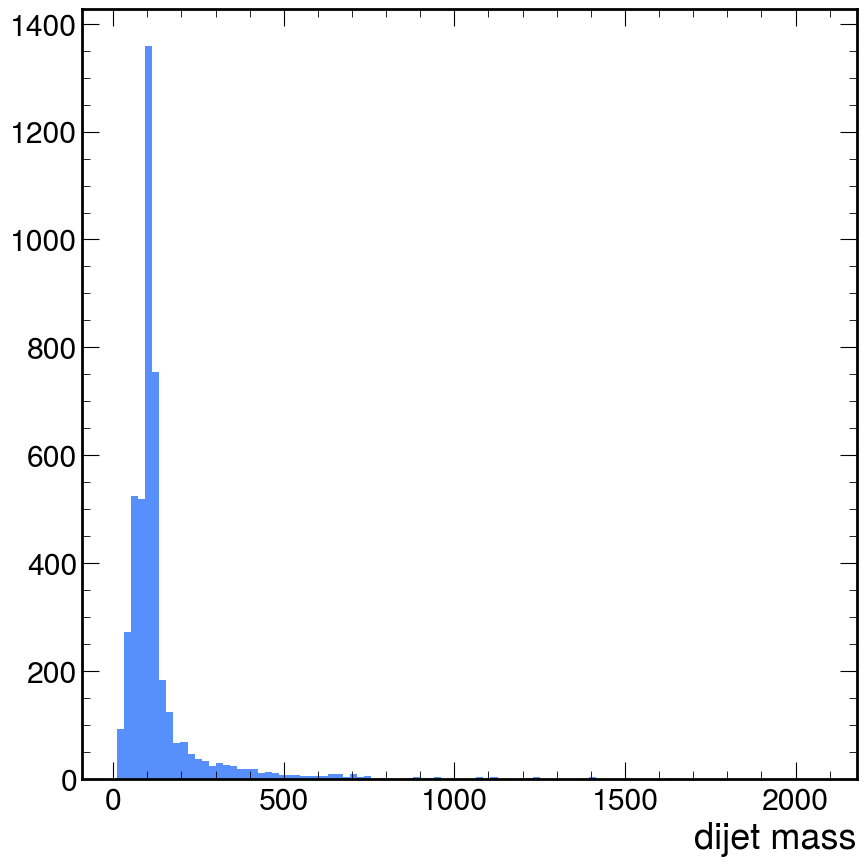

In [16]:
plt.hist(dijet.mass, bins=100);
plt.xlabel("dijet mass")

# Weights

Coffea provides an improved interface to the interpretation of TTrees data formats (specifically for CMS NanoAODs, but other formats are available or under developement, e.g. for ATLAS). Moreover Coffea provides a set of analsysi tools for handling Weights, systematics variation, and cuts.



In [17]:
from coffea.analysis_tools import Weights

Nevents = len(events)
weights = Weights(Nevents)

In [18]:
weights.add("SF1", np.random.sample((Nevents)))

In [19]:
weights.weight()

array([0.33651159, 0.34000791, 0.92501039, ..., 0.91107578, 0.29090744,
       0.27341001])

In [20]:
weights.add?

Signature: weights.add(name, weight, weightUp=None, weightDown=None, shift=False)
Docstring:
Add a new weight

Adds a named correction to the event weight, and optionally also associated
systematic uncertainties.

Parameters
----------
    name : str
        name of correction
    weight : numpy.ndarray
        the nominal event weight associated with the correction
    weightUp : numpy.ndarray, optional
        weight with correction uncertainty shifted up (if available)
    weightDown : numpy.ndarray, optional
        weight with correction uncertainty shifted down. If ``weightUp`` is supplied, and
        the correction uncertainty is symmetric, this can be set to None to auto-calculate
        the down shift as ``1 / weightUp``.
    shift : bool, optional
        if True, interpret weightUp and weightDown as a realtive difference (additive) to the
        nominal value

.. note:: ``weightUp`` and ``weightDown`` are assumed to be rvalue-like and may be modified in-place by this func

Let's now add multilple weights. 

If we want to be able to access the single weights we need to specify `storeIndividual=True`, but we will pay a cost in memory. 
By default all the weights are accumulated in a single vector when added.

In [21]:
weights = Weights(Nevents, storeIndividual=True)
weights.add("SF1", 2.*np.ones(Nevents), 
            weightUp=5.*np.ones(Nevents), 
            weightDown=0.5*np.ones(Nevents))

In [22]:
weights.variations

{'SF1Down', 'SF1Up'}

In [23]:
weights.weight()

array([2., 2., 2., ..., 2., 2., 2.])

In [24]:
weights.weight(modifier="SF1Down")

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [25]:
weights.weight(modifier="SF1Up")

array([5., 5., 5., ..., 5., 5., 5.])

In [26]:
weights.add("SF2", 3.*np.ones(Nevents), 
            weightUp=6.*np.ones(Nevents), 
            weightDown=0.2*np.ones(Nevents))

In [27]:
weights.weight()

array([6., 6., 6., ..., 6., 6., 6.])

In [28]:
weights.partial_weight(include=["SF1"])

array([2., 2., 2., ..., 2., 2., 2.])

In [29]:
weights.variations

{'SF1Down', 'SF1Up', 'SF2Down', 'SF2Up'}

In [30]:
weights.weight(modifier="SF1Up")

array([15., 15., 15., ..., 15., 15., 15.])

In [31]:
weights.weight(modifier="SF2Up")

array([12., 12., 12., ..., 12., 12., 12.])

#### Weights with multiple possible variations

In [32]:
weights = Weights(Nevents)

weights.add_multivariation("SF1", 
            weight=2.*np.ones(Nevents), 
            modifierNames=["stat", "syst"],
            weightsUp=[5.*np.ones(Nevents), 3.*np.ones(Nevents)],
            weightsDown=[0.5*np.ones(Nevents), 0.3*np.ones(Nevents)]
           )

In [33]:
weights.variations

{'SF1_statDown', 'SF1_statUp', 'SF1_systDown', 'SF1_systUp'}

# Cuts

Coffea provides a class that can store several boolean arrays in a memory-efficient mannner and evaluate arbitrary combinations of boolean requirements in an CPU-efficient way. Supported inputs include 1D numpy or awkward arrays. This makes it a good tool to form analysis signal and control regions, and to implement cutflow or “N-1” plots.

In [116]:
from coffea.analysis_tools import PackedSelection

selection = PackedSelection()

selection.add("twoElectron", ak.num(events.Electron) == 2)
selection.add("eleOppSign", ak.sum(events.Electron.charge, axis=1) == 0)
selection.add("noElectron", ak.num(events.Electron) == 0)

selection.add("twoMuon", ak.num(events.Muon) == 2)
selection.add("muOppSign", ak.sum(events.Muon.charge, axis=1) == 0)
selection.add("noMuon", ak.num(events.Muon) == 0)

selection.add(
    "leadPt20",
    # assuming one of `twoElectron` or `twoMuon` is imposed, this implies at least one is above threshold
    ak.any(events.Electron.pt >= 20.0, axis=1) | ak.any(events.Muon.pt >= 20.0, axis=1)
)

print(selection.names)

['twoElectron', 'eleOppSign', 'noElectron', 'twoMuon', 'muOppSign', 'noMuon', 'leadPt20']


In [118]:
selection.all("twoElectron", "noMuon", "leadPt20")

array([False, False, False, ..., False, False, False])

In [120]:
allCuts = {"twoElectron", "noMuon", "leadPt20"}
for cut in allCuts:
    nev = selection.all(*(allCuts - {cut})).sum()
    print(f"Events passing all cuts, ignoring {cut}: {nev}")

nev = selection.all(*allCuts).sum()
print(f"Events passing all cuts: {nev}")

Events passing all cuts, ignoring twoElectron: 1243
Events passing all cuts, ignoring noMuon: 764
Events passing all cuts, ignoring leadPt20: 752
Events passing all cuts: 689


We can also use another syntax as:

In [171]:
selection.require(twoElectron=True, twoMuon=False)

array([False, False, False, ..., False, False, False])

# Applying corrections

Computing and applying corrections is a very general operation needed in data analysis. 
In CMS the **correctionlib** package has been implemented for this task. The purpose of this library is to provide a well-structured JSON data format for a wide variety of ad-hoc correction factors encountered in a typical HEP analysis and a companion evaluation tool suitable for use in C++ and python programs. 

Let's build a correction factor

In [52]:
H = (
    Hist.new.Regular(10, 15, 100, name="jetpt")
    .Regular(10, -3, 3, name="jeteta")
    .StrCategory(["MC", "Data"], name="event_type")
    .IntCategory([2016, 2017], name="year")
    .Weight())


In [53]:
events_MC = NanoEventsFactory.from_root(
    datasets['DYJetsToLL']['files'][0],
    schemaclass=NanoAODSchema.v7,
    metadata={"dataset": "DYJets"},
    entry_stop = 10000
).events()

events_data = NanoEventsFactory.from_root(
    datasets['DoubleMuon']['files'][0],
    schemaclass=NanoAODSchema.v7,
    metadata={"dataset": "DYJets"},
    entry_stop = 10000
).events()

In [54]:
mask_2j_MC = ak.num(events_MC.Jet, axis=1)>=2
mask_2j_data = ak.num(events_data.Jet, axis=1)>=2

H.fill(events_MC[mask_2j_MC].Jet[:,0].pt,
            events_MC[mask_2j_MC].Jet[:,0].eta,
            event_type="MC",
            year=2016
      )
H.fill(events_MC[mask_2j_MC].Jet[:,0].pt,
            events_MC[mask_2j_MC].Jet[:,0].eta,
            event_type="MC",
            year=2017,
            weight=np.ones(np.sum(mask_2j_MC))*2.
      )
H.fill(events_data[mask_2j_data].Jet[:,0].pt, 
            events_data[mask_2j_data].Jet[:,0].eta,
            event_type="Data",
            year=2016
      )
H.fill(events_data[mask_2j_data].Jet[:,0].pt, 
            events_data[mask_2j_data].Jet[:,0].eta,
            event_type="Data",
            year=2017
      )

Hist(
  Regular(10, 15, 100, name='jetpt'),
  Regular(10, -3, 3, name='jeteta'),
  StrCategory(['MC', 'Data'], name='event_type'),
  IntCategory([2016, 2017], name='year'),
  storage=Weight()) # Sum: WeightedSum(value=36756, variance=51636) (WeightedSum(value=45598, variance=63198) with flow)

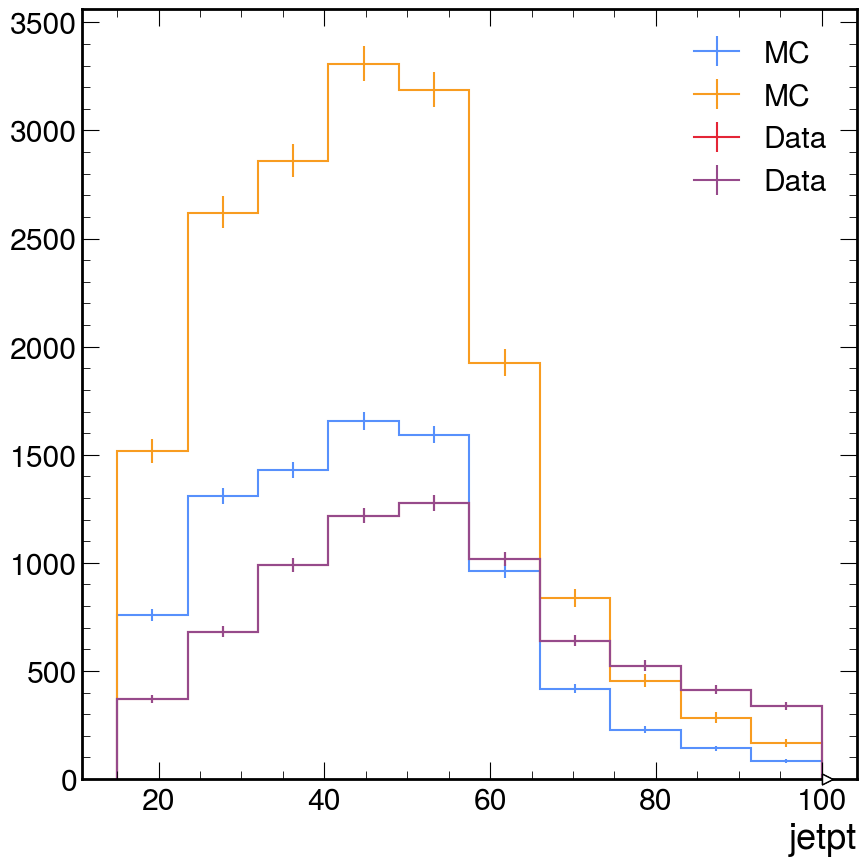

In [55]:
H[{"event_type":"MC","jeteta":sum}].plot(label="MC")
H[{"event_type":"Data","jeteta":sum}].plot(label="Data")
plt.legend()

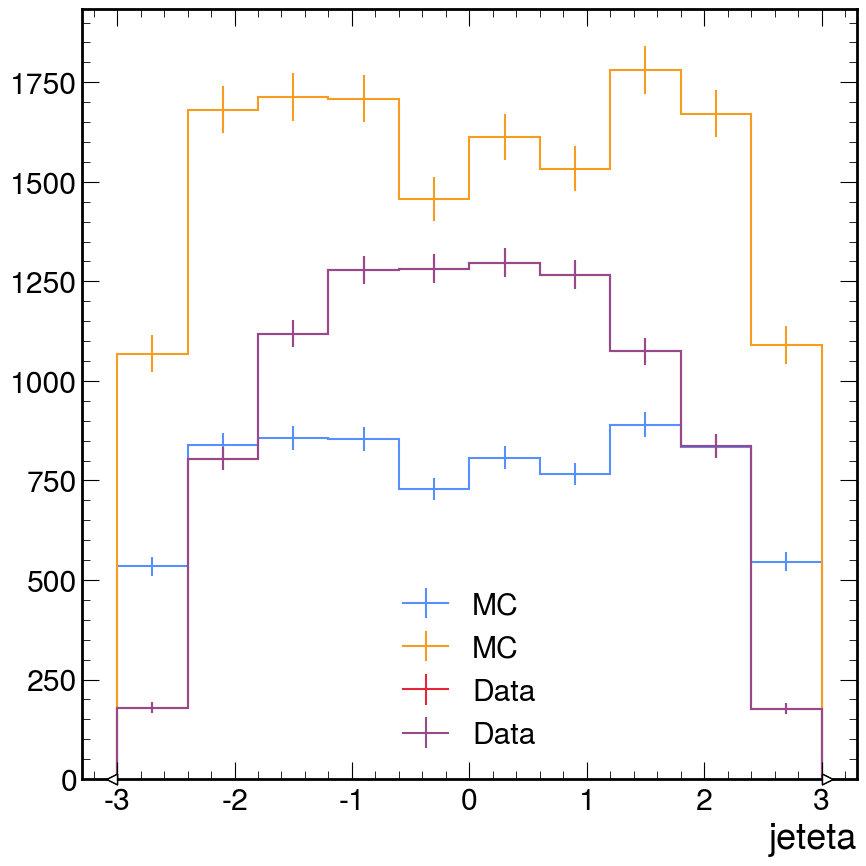

In [56]:
H[{"event_type":"MC","jetpt":sum}].plot(label="MC")
H[{"event_type":"Data","jetpt":sum}].plot(label="Data")
plt.legend()

Let's image we want to compute a correction factor from the ratio of the two histograms above (it does not make any physical sense, but just to demonstrate the correctionlib function..)

In [84]:
H[{"event_type":"MC"}].values().shape

(10, 10, 2)

In [66]:
ratio = np.where(
         H[{"event_type":"MC"}].values() > 0.,
         H[{"event_type":"Data"}].values() / H[{"event_type":"MC"}].values(),
         1.)

In [69]:
H.axes

(Regular(10, 15, 100, name='jetpt'),
 Regular(10, -3, 3, name='jeteta'),
 StrCategory(['MC', 'Data'], name='event_type'),
 IntCategory([2016, 2017], name='year'))

In [87]:
sfhist = Hist(H.axes[0], H.axes[1], H.axes[3], data=ratio)
sfhist

Hist(
  Regular(10, 15, 100, name='jetpt'),
  Regular(10, -3, 3, name='jeteta'),
  IntCategory([2016, 2017], name='year'),
  storage=Double()) # Sum: 252.99476405517444

In [86]:
sfhist[:,:, 2016j]

Hist(
  Regular(10, 15, 100, name='jetpt'),
  Regular(10, -3, 3, name='jeteta'),
  storage=Double()) # Sum: 168.66317603678297

In [88]:
import correctionlib, rich
import correctionlib.convert

# without a name, the resulting object will fail validation
sfhist.name = "MC_to_Data"
sfhist.label = "out"

clibcorr = correctionlib.convert.from_histogram(sfhist)
clibcorr.description = "Reweights gen2 to agree with gen1"
# set overflow bins behavior (default is to raise an error when out of bounds)
clibcorr.data.flow = "clamp"

cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description="my custom corrections",
    corrections=[clibcorr],
)
rich.print(cset)

with open("mycorrections.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

CorrectionSet (schema v2)
my custom corrections
📂
└── 📈 MC_to_Data (v0)
    Reweights gen2 to agree with gen1
    Node counts: MultiBinning: 1, Category: 100
    ╭───────────── ▶ input ─────────────╮ ╭──────────── ▶ input ────────────╮ ╭───── ▶ input ──────╮
    │ jetpt (real)                      │ │ jeteta (real)                   │ │ year (int)         │
    │ jetpt                             │ │ jeteta                          │ │ year               │
    │ Range: [15.0, 100.0), overflow ok │ │ Range: [-3.0, 3.0), overflow ok │ │ Values: 2016, 2017 │
    ╰───────────────────────────────────╯ ╰─────────────────────────────────╯ ╰────────────────────╯
    ╭─── ◀ output ───╮
    │ out (real)     │
    │ No description │
    ╰────────────────╯

/tmp/ipykernel_2825/2882992232.py:21: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  fout.write(cset.json(exclude_unset=True))


In [89]:
ceval = correctionlib.CorrectionSet.from_file("mycorrections.json")

In [90]:
list(ceval.keys())

['MC_to_Data']

In [97]:
ceval['MC_to_Data'].evaluate(ak.flatten(events_MC[mask_2j].Jet.pt), 
                             ak.flatten(events_MC[mask_2j].Jet.eta),
                             2016)

array([0.93984962, 0.98224852, 0.5       , ..., 0.58441558, 0.2173913 ,
       0.2173913 ])

In [98]:
ceval['MC_to_Data'].evaluate(ak.flatten(events_MC[mask_2j].Jet.pt), 
                             ak.flatten(events_MC[mask_2j].Jet.eta),
                             2018)

IndexError: Index not available in Category for input argument 2 val: 2018

## Exercise

Add an additional axis for the "year" of the scale factor

# Full analysis with Coffea

Coffea provides utilities to define an **analysis workflow**, and apply it on multiple ROOT files and dataset. 

Events are processed in "chunks" with a map-reduce pattern. The user defines the analysis workflow in a Processor class which output a set of results which are **accumulated** over the full dataset. 

Coffea relies mainly on uproot to provide access to ROOT files for analysis. As a usual analysis will involve processing tens to thousands of files, totalling gigabytes to terabytes of data, there is a certain amount of work to be done to build a parallelized framework to process the data in a reasonable amount of time. Of course, one can work directly within uproot to achieve this, as we’ll show in the beginning, but coffea provides the coffea.processor module, which allows users to worry just about the actual analysis code and not about how to implement efficient parallelization, assuming that the parallization is a trivial map-reduce operation (e.g. filling histograms and adding them together). The module provides the following key features:

- A ProcessorABC abstract base class that can be derived from to implement the analysis code;
- A NanoEvents interface to the arrays being read from the TTree as inputs;
- A generic accumulate() utility to reduce the outputs to a single result
- and A set of parallel executors to access multicore processing or distributed computing systems such as Dask, Parsl, Spark, WorkQueue, and others.


### Accumulator semantic

In [100]:
from coffea.processor import accumulate

accumulate([
    {"num": 0, "val": 3.1},
    {"num": 2, "val": 4.0, "thing": {"a", "b"}},
    {"num": 2, "val": 4.0, "thing": {"a", "c"}},
])


{'num': 4, 'val': 11.1, 'thing': {'a', 'b', 'c'}}

Also histogram can be accumulated

In [101]:
import hist

def makehist():
    return hist.Hist.new.Reg(10, 0, 1).Double()

h = accumulate([
    makehist().fill([0.1, 0.1, 0.3]),
    makehist().fill([0.1, 0.3, 0.5]),
])
print(h.values())
h

[0. 3. 0. 2. 0. 1. 0. 0. 0. 0.]


Hist(Regular(10, 0, 1, label='Axis 0'), storage=Double()) # Sum: 6.0

## Coffea workflow

Let's write below a full analysis example and then we will build a Coffea processor around it: 

In [102]:
events = NanoEventsFactory.from_root(
    datasets['DYJetsToLL']['files'][0],
    schemaclass=NanoAODSchema.v7,
    metadata={"dataset": "DYJets"},
    entry_stop = 5000
).events()


In [103]:
selection = PackedSelection()

selection.add("twoElectron", ak.num(events.Electron) == 2)
selection.add("eleOppSign", ak.sum(events.Electron.charge, axis=1) == 0)
selection.add("noElectron", ak.num(events.Electron) == 0)

selection.add("twoMuon", ak.num(events.Muon) == 2)
selection.add("muOppSign", ak.sum(events.Muon.charge, axis=1) == 0)
selection.add("noMuon", ak.num(events.Muon) == 0)

selection.add(
    "leadPt20",
    # assuming one of `twoElectron` or `twoMuon` is imposed, this implies at least one is above threshold
    ak.any(events.Electron.pt >= 20.0, axis=1) | ak.any(events.Muon.pt >= 20.0, axis=1)
)


weights = Weights(len(events))

weights.add("genWeight", events.genWeight)
weights.add(
    "alphaS",
    # in NanoAOD, the generator weights are already stored with respect to nominal
    weight=np.ones(len(events)),
    # 31 => alphas(MZ)=0.1165 central value; 32 => alphas(MZ)=0.1195
    weightUp=events.LHEPdfWeight[:, 32],
    weightDown=events.LHEPdfWeight[:, 31],
)
weights.add("lumi", np.ones(len(events))*7653.261227, np.ones(len(events))*7653.261227*1.025, np.ones(len(events))*7653.261227*0.975 )# /pb)
weights.add("XS", np.ones(len(events))*6077.22) #pb
            

# Let's define some regions    
regions = {
    "ee": {"twoElectron": True, "noMuon": True, "leadPt20": True, "eleOppSign": True},
    "eeSS": {"twoElectron": True, "noMuon": True, "leadPt20": True, "eleOppSign": False},
    "mm": {"twoMuon": True, "noElectron": True, "leadPt20": True, "muOppSign": True},
    "mmSS": {"twoMuon": True, "noElectron": True, "leadPt20": True, "muOppSign": False},
}

# one output histogram
masshist = (
    hist.Hist.new
    .StrCat(regions.keys(), name="region")
    .StrCat(["nominal"] + list(weights.variations), name="systematic")
    .Reg(60, 60, 120, name="mass", label="$m_{ll}$ [GeV]")
    .Weight()
)
leppt_hist = (
    hist.Hist.new
    .StrCat(regions.keys(), name="region")
    .StrCat(["nominal"] + list(weights.variations), name="systematic")
    .Reg(30, 10, 120, name="leppt", label="Lepton $p_T$ [GeV]")
    .Weight()
)

for region, cuts in regions.items():
    goodevent = selection.require(**cuts)

    if region.startswith("ee"):
        mass = events.Electron[goodevent].sum().mass
        leppt = events.Electron[goodevent][:,0].pt
    elif region.startswith("mm"):
        mass = events.Muon[goodevent].sum().mass
        leppt = events.Muon[goodevent][:,0].pt

    masshist.fill(
        region=region,
        systematic="nominal",
        mass=mass,
        weight=weights.weight()[goodevent],
    )
    leppt_hist.fill(
            region=region,
            systematic="nominal",
            leppt=leppt,
            weight=weights.weight()[goodevent],
        )
    for syst in weights.variations:
        masshist.fill(
            region=region,
            systematic=syst,
            mass=mass,
            weight=weights.weight(syst)[goodevent],
        )
        leppt_hist.fill(
            region=region,
            systematic=syst,
            leppt=leppt,
            weight=weights.weight(syst)[goodevent],
        )

out = {
    events.metadata["dataset"]: {
        "sumw": ak.sum(events.genWeight),
        "histograms": {
            "mass": masshist,
            "lepton_pt": leppt_hist, 
        },
        "weightStats": weights.weightStatistics,
    }
}

out

{'DYJets': {'sumw': 5000.0,
  'histograms': {'mass': Hist(
     StrCategory(['ee', 'eeSS', 'mm', 'mmSS'], name='region'),
     StrCategory(['nominal', 'lumiDown', 'alphaSDown', 'lumiUp', 'alphaSUp'], name='systematic'),
     Regular(60, 60, 120, name='mass', label='$m_{ll}$ [GeV]'),
     storage=Weight()) # Sum: WeightedSum(value=2.97106e+11, variance=1.38285e+19) (WeightedSum(value=3.34796e+11, variance=1.55828e+19) with flow),
   'lepton_pt': Hist(
     StrCategory(['ee', 'eeSS', 'mm', 'mmSS'], name='region'),
     StrCategory(['nominal', 'lumiDown', 'alphaSDown', 'lumiUp', 'alphaSUp'], name='systematic'),
     Regular(30, 10, 120, name='leppt', label='Lepton $p_T$ [GeV]'),
     storage=Weight()) # Sum: WeightedSum(value=3.31537e+11, variance=1.5431e+19) (WeightedSum(value=3.34796e+11, variance=1.55828e+19) with flow)},
  'weightStats': {'genWeight': WeightStatistics(sumw=5000.0, sumw2=5000.0, minw=1.0, maxw=1.0, n=5000),
   'alphaS': WeightStatistics(sumw=5000.0, sumw2=5000.0, minw=

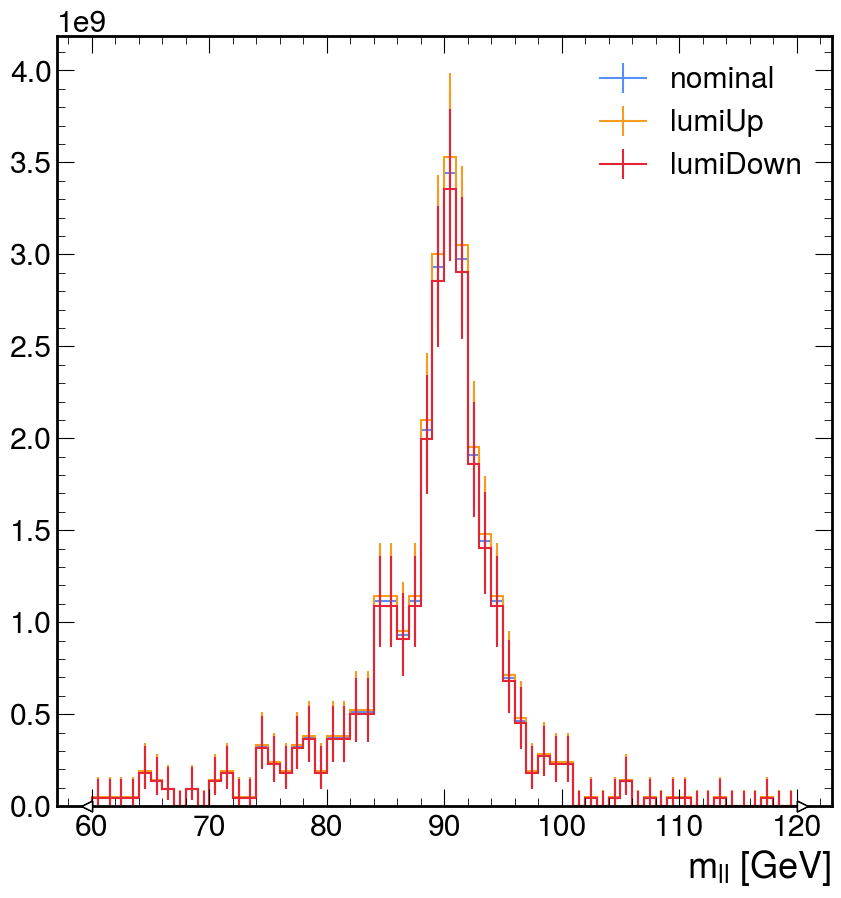

In [104]:
out["DYJets"]["histograms"]["mass"][{"region":"ee", "systematic":"nominal"}].plot(label="nominal")
out["DYJets"]["histograms"]["mass"][{"region":"ee", "systematic":"lumiUp"}].plot(label="lumiUp")
out["DYJets"]["histograms"]["mass"][{"region":"ee", "systematic":"lumiDown"}].plot(label="lumiDown")
plt.legend()

We have tested our analysis workflow on a single chunk of a MC file, now we need to apply it on all the dataset, also distinguishing between data and MC events

## Coffea processor

In [105]:
from coffea import processor

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        dataset = events.metadata['dataset']
        isMC = events.metadata["isMC"] # reading from the dataset metadata
        
        selection = PackedSelection()
        selection.add("twoElectron", ak.num(events.Electron) == 2)
        selection.add("eleOppSign", ak.sum(events.Electron.charge, axis=1) == 0)
        selection.add("noElectron", ak.num(events.Electron) == 0)
        
        selection.add("twoMuon", ak.num(events.Muon) == 2)
        selection.add("muOppSign", ak.sum(events.Muon.charge, axis=1) == 0)
        selection.add("noMuon", ak.num(events.Muon) == 0)
        
        selection.add(
            "leadPt20",
            # assuming one of `twoElectron` or `twoMuon` is imposed, this implies at least one is above threshold
            ak.any(events.Electron.pt >= 20.0, axis=1) | ak.any(events.Muon.pt >= 20.0, axis=1)
        )
        

        weights = Weights(len(events))
        if isMC:
            weights.add("genWeight", events.genWeight)
            weights.add(
                "alphaS",
                # in NanoAOD, the generator weights are already stored with respect to nominal
                weight=np.ones(len(events)),
                # 31 => alphas(MZ)=0.1165 central value; 32 => alphas(MZ)=0.1195
                weightUp=events.LHEPdfWeight[:, 32],
                weightDown=events.LHEPdfWeight[:, 31],
            )
            weights.add("lumi", np.ones(len(events))*7653.261227, np.ones(len(events))*7653.261227*1.025, np.ones(len(events))*7653.261227*0.975 )# /pb)
            weights.add("XS", np.ones(len(events))*6077.22) #pb
        else:
            weights.add("nominal", np.ones(len(events)))
                        
        
        # Let's define some regions    
        regions = {
            "ee": {"twoElectron": True, "noMuon": True, "leadPt20": True, "eleOppSign": True},
            "eeSS": {"twoElectron": True, "noMuon": True, "leadPt20": True, "eleOppSign": False},
            "mm": {"twoMuon": True, "noElectron": True, "leadPt20": True, "muOppSign": True},
            "mmSS": {"twoMuon": True, "noElectron": True, "leadPt20": True, "muOppSign": False},
        }
        
        # one output histogram
        masshist = (
            hist.Hist.new
            .StrCat(regions.keys(), name="region")
            .StrCat(["nominal"] + list(sorted(weights.variations)), name="systematic", growth=False)
            .Reg(60, 60, 120, name="mass", label="$m_{ll}$ [GeV]")
            .Weight()
        )
        leppt_hist = (
            hist.Hist.new
            .StrCat(regions.keys(), name="region")
            .StrCat(["nominal"] + list(sorted(weights.variations)), name="systematic", growth=False)
            .Reg(30, 10, 120, name="leppt", label="Lepton $p_T$ [GeV]")
            .Weight()
        )
        
        for region, cuts in regions.items():
            goodevent = selection.require(**cuts)
        
            if region.startswith("ee"):
                mass = events.Electron[goodevent].sum().mass
                leppt = events.Electron[goodevent][:,0].pt
            elif region.startswith("mm"):
                mass = events.Muon[goodevent].sum().mass
                leppt = events.Muon[goodevent][:,0].pt
        
            masshist.fill(
                region=region,
                systematic="nominal",
                mass=mass,
                weight=weights.weight()[goodevent],
            )
            leppt_hist.fill(
                    region=region,
                    systematic="nominal",
                    leppt=leppt,
                    weight=weights.weight()[goodevent],
                )
            for syst in weights.variations:
                masshist.fill(
                    region=region,
                    systematic=syst,
                    mass=mass,
                    weight=weights.weight(syst)[goodevent],
                )
                leppt_hist.fill(
                    region=region,
                    systematic=syst,
                    leppt=leppt,
                    weight=weights.weight(syst)[goodevent],
                )
        
        return {
            events.metadata["dataset"]: {
                "sumw": ak.sum(events.genWeight) if isMC else len(events),
                "histograms": {
                    "mass": masshist,
                    "lepton_pt": leppt_hist, 
                }
            }
        }
        

    def postprocess(self, accumulator):
        pass

In [106]:
events_MC = NanoEventsFactory.from_root(
    datasets['DYJetsToLL']['files'][1],
    schemaclass=NanoAODSchema.v7,
    metadata={
        "dataset": "DYJets",
        "isMC": True
    },
    entry_stop = 5000
).events()

events_DATA = NanoEventsFactory.from_root(
    datasets['DoubleMuon']['files'][1],
    schemaclass=NanoAODSchema.v7,
    metadata={
        "dataset": "DoubleMuon",
        "isMC": False
    },
    entry_stop = 5000
).events()



p = MyProcessor()
out_MC = p.process(events_MC)
out_Data = p.process(events_DATA)


The processor is just a wrapper around the analysis workflow. We now need to scale it up to our full dataset definition.

Just for visualization, let's rescale the MC histogram to the data normalization

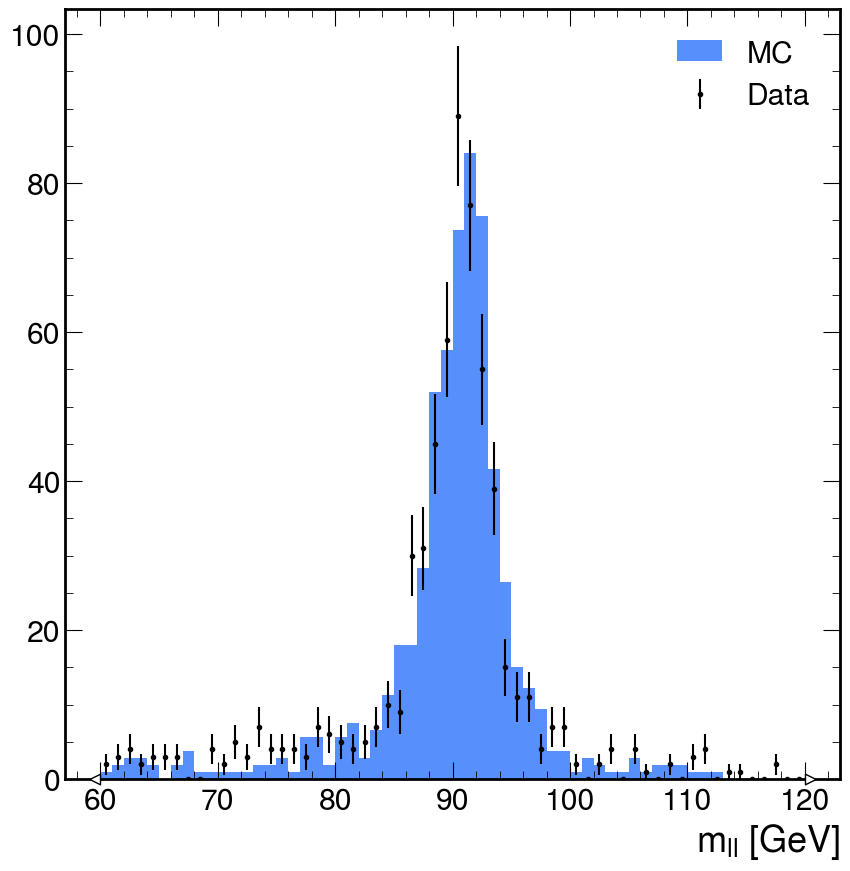

In [107]:
h_Data = out_Data["DoubleMuon"]["histograms"]["mass"][{"region":"mm", "systematic":"nominal"}]
h_MC = out_MC["DYJets"]["histograms"]["mass"][{"region":"mm", "systematic":"nominal"}]

rescaling = (h_Data.sum().value / h_MC.sum().value)
h_MC *= rescaling

h_MC.plot(label="MC", histtype="fill")
plt.errorbar(h_Data.axes[0].centers, h_Data.values(), 
             yerr= np.sqrt(h_Data.variances()), 
             marker=".", c="black", linestyle="none",
            label="Data")

plt.legend()

# Scale up

In [108]:
import yaml
with open("datasets.yaml") as f:
    fileset = yaml.safe_load(f)

In [110]:
max_files = 5
for key, value in fileset.items():
    value["files"] = value["files"][0:max_files]

fileset

{'DoubleMuon': {'metadata': {'opendata-entry': 'https://opendata.cern.ch/record/30522',
   'isMC': False,
   'sample': 'Data'},
  'files': ['root://eospublic.cern.ch//eos/opendata/cms/Run2016G/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v2/2430000/05DD095C-F6C3-9A4F-9FB3-348A5A6403D5.root',
   'root://eospublic.cern.ch//eos/opendata/cms/Run2016G/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v2/2430000/209D94D9-B6D5-A34B-A2A3-CBB7E4EA8ADF.root',
   'root://eospublic.cern.ch//eos/opendata/cms/Run2016G/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v2/2430000/23A0C786-B116-F346-81C1-18EF4716C097.root',
   'root://eospublic.cern.ch//eos/opendata/cms/Run2016G/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v2/2430000/2631F9B1-3B3E-7E4A-BE75-FC57E322C981.root',
   'root://eospublic.cern.ch//eos/opendata/cms/Run2016G/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v2/2430000/26A77DF8-54A5-7B44-B1BB-5B93CFF5C9C6.root']},
 'DoubleEG': {'metadata': {'opendata-entry': 'https://opendata.cern.ch/recor

### Iterative runner

Runs single-thread locally --> useful for debugging and testing

In [111]:
processor_workflow = MyProcessor()

run = processor.Runner(
            executor=processor.IterativeExecutor(),
            chunksize=5000,
            maxchunks=20,
            #skipbadfiles=True,
            schema=processor.NanoAODSchema,
            format="root",
        )
output = run(fileset,
             treename="Events",
             processor_instance=processor_workflow)


Output()

Output()


KeyboardInterrupt



### Multi-processing runner

Runs multiprocess locally --> useful for quick processing without scaling on a cluster

In [112]:
run = processor.Runner(
            executor=processor.FuturesExecutor(workers=8),
            chunksize=10000,
            maxchunks=20,
            #skipbadfiles=True,
            schema=processor.NanoAODSchema,
            format="root",
        )
output = run(fileset,
             treename="Events",
             processor_instance=MyProcessor())
        

Output()

/opt/conda/lib/python3.11/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


In [113]:
output

{'DYJetsToLL': {'sumw': 199800.0,
  'histograms': {'mass': Hist(
     StrCategory(['ee', 'eeSS', 'mm', 'mmSS'], name='region'),
     StrCategory(['nominal', 'alphaSDown', 'alphaSUp', 'lumiDown', 'lumiUp'], name='systematic'),
     Regular(60, 60, 120, name='mass', label='$m_{ll}$ [GeV]'),
     storage=Weight()) # Sum: WeightedSum(value=1.14793e+13, variance=5.34293e+20) (WeightedSum(value=1.28817e+13, variance=5.99572e+20) with flow),
   'lepton_pt': Hist(
     StrCategory(['ee', 'eeSS', 'mm', 'mmSS'], name='region'),
     StrCategory(['nominal', 'alphaSDown', 'alphaSUp', 'lumiDown', 'lumiUp'], name='systematic'),
     Regular(30, 10, 120, name='leppt', label='Lepton $p_T$ [GeV]'),
     storage=Weight()) # Sum: WeightedSum(value=1.27664e+13, variance=5.942e+20) (WeightedSum(value=1.28817e+13, variance=5.99572e+20) with flow)}},
 'DoubleEG': {'sumw': 200780,
  'histograms': {'mass': Hist(
     StrCategory(['ee', 'eeSS', 'mm', 'mmSS'], name='region'),
     StrCategory(['nominal'], name='

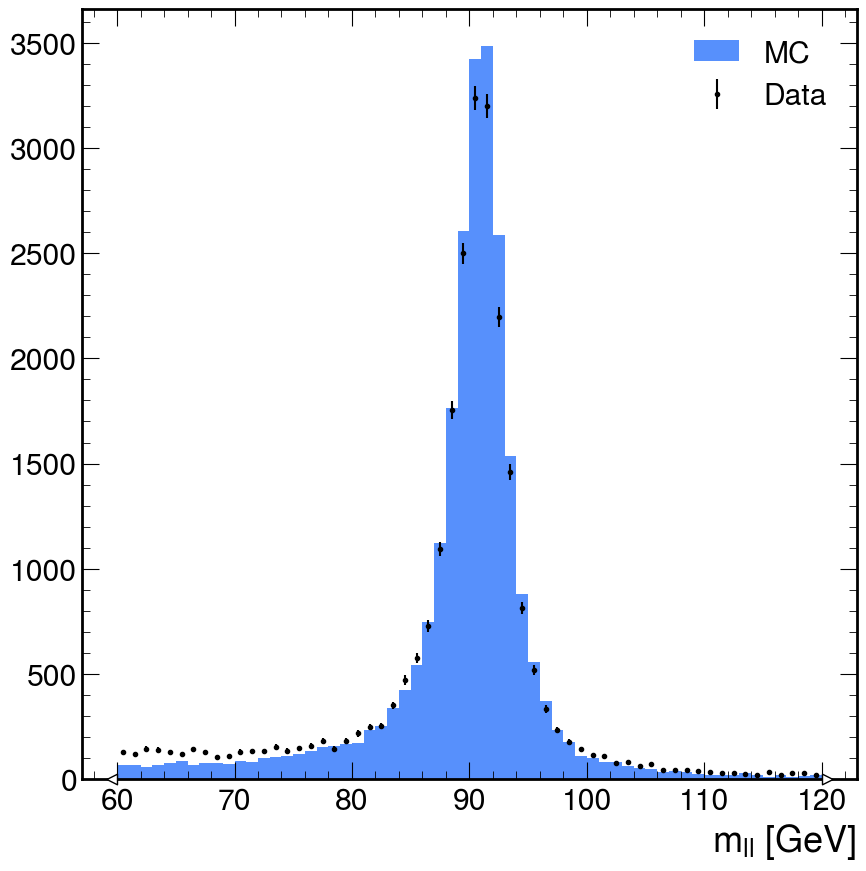

In [114]:
h_Data = output["DoubleMuon"]["histograms"]["mass"][{"region":"mm", "systematic":"nominal"}]
h_MC = output["DYJetsToLL"]["histograms"]["mass"][{"region":"mm", "systematic":"nominal"}]

rescaling = (h_Data.sum().value / h_MC.sum().value)
h_MC *= rescaling  # rescaling just for plotting 

h_MC.plot(label="MC", histtype="fill")
plt.errorbar(h_Data.axes[0].centers, h_Data.values(), 
             yerr= np.sqrt(h_Data.variances()), 
             marker=".", c="black", linestyle="none",
            label="Data")

plt.legend()

### Dask runner

In [115]:
from dask.distributed import Client

client = Client("tcp://dask-davalsecchi-aczk1-scheduler.jhub:8786")
client

<Client: 'tcp://10.42.6.175:8786' processes=4 threads=4, memory=8.00 GiB>

In [116]:
dask_executor = processor.dask_executor(client=client, 
                                   treereduction=20,  # number of elements for map-reduce
                                   retries = 5)

run = processor.Runner(
            executor=dask_executor,
            chunksize=50000,
            maxchunks=50,
            #skipbadfiles=True,
            schema=processor.NanoAODSchema,
            format="root",
        )
output = run(fileset,
             treename="Events",
             processor_instance=MyProcessor())
        

In [117]:
output

{'DoubleMuon': {'sumw': 2496760,
  'histograms': {'mass': Hist(
     StrCategory(['ee', 'eeSS', 'mm', 'mmSS'], name='region'),
     StrCategory(['nominal'], name='systematic'),
     Regular(60, 60, 120, name='mass', label='$m_{ll}$ [GeV]'),
     storage=Weight()) # Sum: WeightedSum(value=333807, variance=333807) (WeightedSum(value=760890, variance=760890) with flow),
   'lepton_pt': Hist(
     StrCategory(['ee', 'eeSS', 'mm', 'mmSS'], name='region'),
     StrCategory(['nominal'], name='systematic'),
     Regular(30, 10, 120, name='leppt', label='Lepton $p_T$ [GeV]'),
     storage=Weight()) # Sum: WeightedSum(value=752318, variance=752318) (WeightedSum(value=760890, variance=760890) with flow)}},
 'DYJetsToLL': {'sumw': 2512193.0,
  'histograms': {'mass': Hist(
     StrCategory(['ee', 'eeSS', 'mm', 'mmSS'], name='region'),
     StrCategory(['nominal', 'alphaSDown', 'alphaSUp', 'lumiDown', 'lumiUp'], name='systematic'),
     Regular(60, 60, 120, name='mass', label='$m_{ll}$ [GeV]'),
    

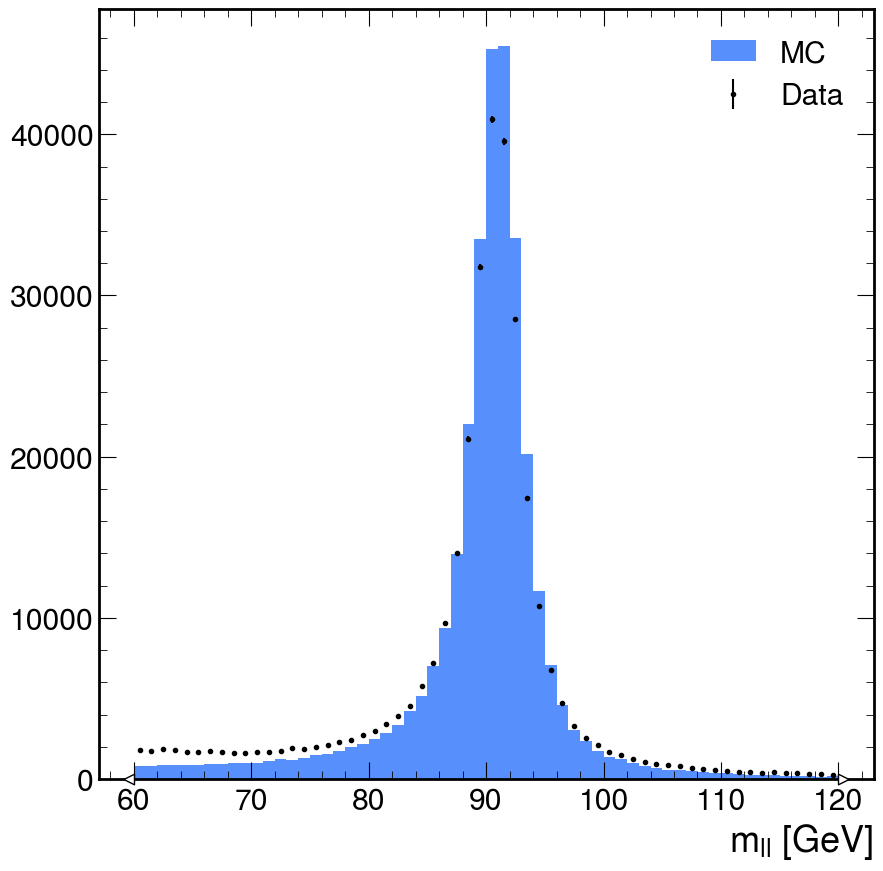

In [118]:
h_Data = output["DoubleMuon"]["histograms"]["mass"][{"region":"mm", "systematic":"nominal"}]
h_MC = output["DYJetsToLL"]["histograms"]["mass"][{"region":"mm", "systematic":"nominal"}]

rescaling = (h_Data.sum().value / h_MC.sum().value)
h_MC *= rescaling  # rescaling just for plotting 

h_MC.plot(label="MC", histtype="fill")
plt.errorbar(h_Data.axes[0].centers, h_Data.values(), 
             yerr= np.sqrt(h_Data.variances()), 
             marker=".", c="black", linestyle="none",
            label="Data")

plt.legend()

In [119]:
output

{'DoubleMuon': {'sumw': 2496760,
  'histograms': {'mass': Hist(
     StrCategory(['ee', 'eeSS', 'mm', 'mmSS'], name='region'),
     StrCategory(['nominal'], name='systematic'),
     Regular(60, 60, 120, name='mass', label='$m_{ll}$ [GeV]'),
     storage=Weight()) # Sum: WeightedSum(value=333807, variance=333807) (WeightedSum(value=760890, variance=760890) with flow),
   'lepton_pt': Hist(
     StrCategory(['ee', 'eeSS', 'mm', 'mmSS'], name='region'),
     StrCategory(['nominal'], name='systematic'),
     Regular(30, 10, 120, name='leppt', label='Lepton $p_T$ [GeV]'),
     storage=Weight()) # Sum: WeightedSum(value=752318, variance=752318) (WeightedSum(value=760890, variance=760890) with flow)}},
 'DYJetsToLL': {'sumw': 2512193.0,
  'histograms': {'mass': Hist(
     StrCategory(['ee', 'eeSS', 'mm', 'mmSS'], name='region'),
     StrCategory(['nominal', 'alphaSDown', 'alphaSUp', 'lumiDown', 'lumiUp'], name='systematic'),
     Regular(60, 60, 120, name='mass', label='$m_{ll}$ [GeV]'),
    

In [122]:
from coffea.util import save, load

save(output, "output.coffea")

In [123]:
out = load("output.coffea")

In [124]:
out

{'DoubleMuon': {'sumw': 2496760,
  'histograms': {'mass': Hist(
     StrCategory(['ee', 'eeSS', 'mm', 'mmSS'], name='region'),
     StrCategory(['nominal'], name='systematic'),
     Regular(60, 60, 120, name='mass', label='$m_{ll}$ [GeV]'),
     storage=Weight()) # Sum: WeightedSum(value=333807, variance=333807) (WeightedSum(value=760890, variance=760890) with flow),
   'lepton_pt': Hist(
     StrCategory(['ee', 'eeSS', 'mm', 'mmSS'], name='region'),
     StrCategory(['nominal'], name='systematic'),
     Regular(30, 10, 120, name='leppt', label='Lepton $p_T$ [GeV]'),
     storage=Weight()) # Sum: WeightedSum(value=752318, variance=752318) (WeightedSum(value=760890, variance=760890) with flow)}},
 'DYJetsToLL': {'sumw': 2512193.0,
  'histograms': {'mass': Hist(
     StrCategory(['ee', 'eeSS', 'mm', 'mmSS'], name='region'),
     StrCategory(['nominal', 'alphaSDown', 'alphaSUp', 'lumiDown', 'lumiUp'], name='systematic'),
     Regular(60, 60, 120, name='mass', label='$m_{ll}$ [GeV]'),
    

# Exercise

1. Add a new category in the Z analysis, low and high Jet HT (sum of the absolute value of Jets pt)
2. Add this category as a new axis in the output histogram. 